### Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

## Importing dataset

In [4]:
data = pd.read_csv('gold_monthly_csv.csv')
data.describe()

,Price
count,847.000000
mean,416.556906
std,453.665313
min,34.490000
25%,35.190000
50%,319.622000
75%,447.029000
max,1840.807000


In [5]:
data.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    847 non-null    object 
 1   Price   847 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.4+ KB


# Exploratory data analysis

In [7]:
print(f"Data range of gold prices available from - {data.loc[:,'Date'][0]} to {data.loc[:,'Date'][len(data)-1]}")

Data range of gold prices available from - 1950-01 to 2020-07


In [8]:
date = pd.date_range(start='1/1/1950', end='8/1/2020', freq='M')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='M')

In [9]:
data['Month']= date
data.drop('Date', axis =1, inplace=True)
data = data.set_index('Month')
data.head()

,Price
Month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


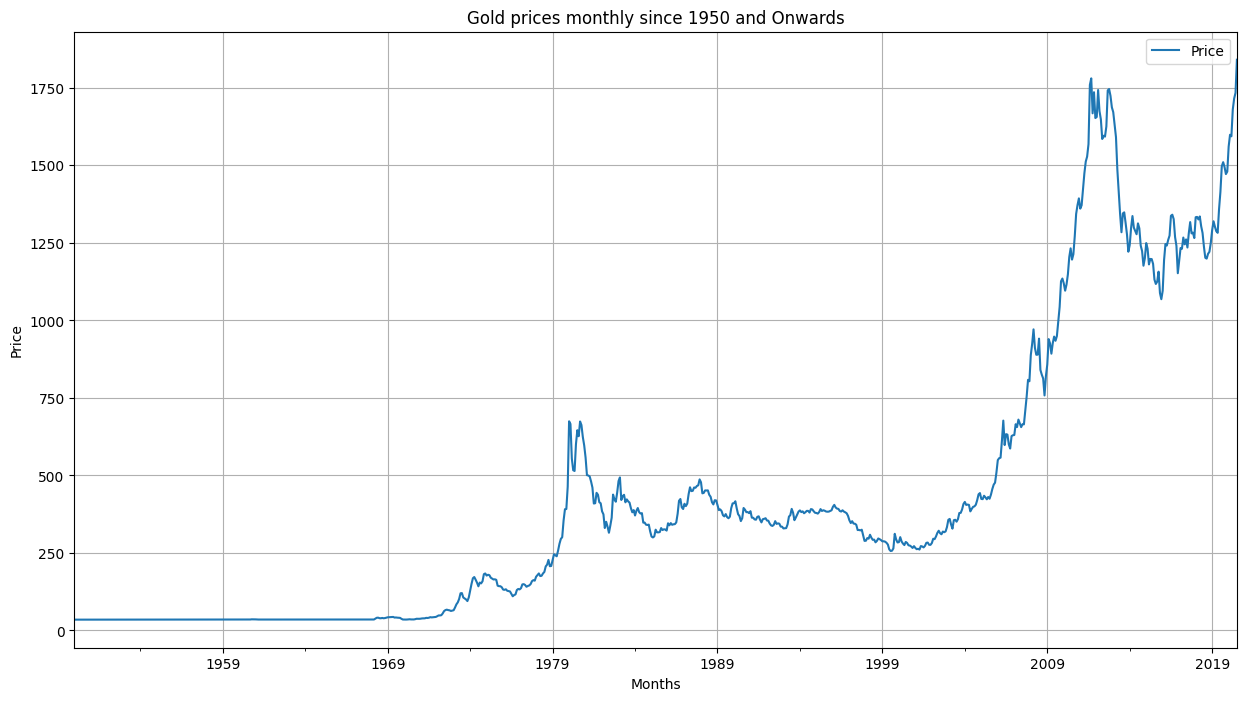

In [11]:
data.plot(figsize=(15,8))
plt.title('Gold prices monthly since 1950 and Onwards')
plt.xlabel('Months')
plt.ylabel('Price')
plt.grid();

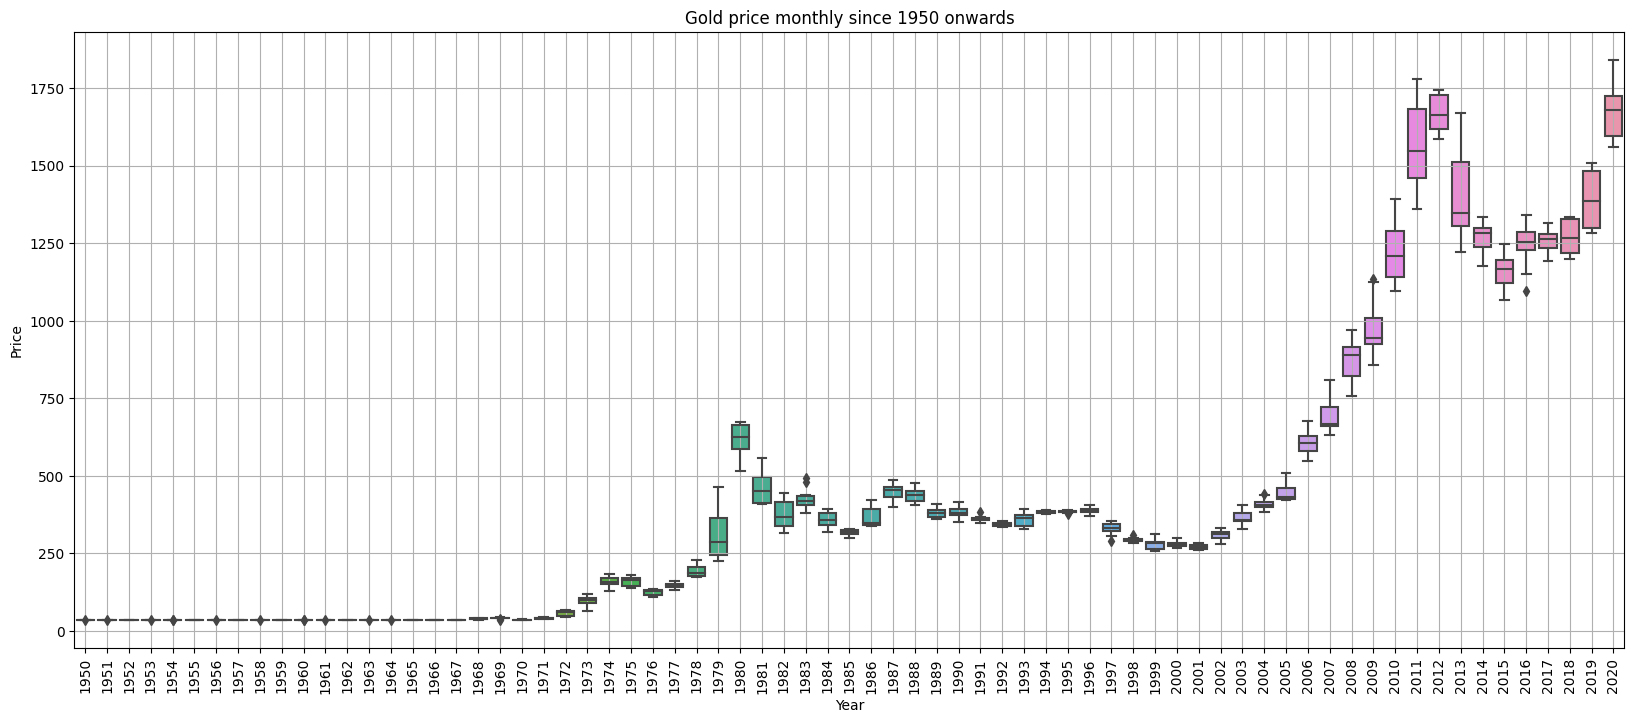

In [12]:
_, ax = plt.subplots(figsize=(20,8))
sns.boxplot(x = data.index.year, y= data.values[:,0], ax=ax)
plt.title('Gold price monthly since 1950 onwards')
plt.xlabel('Year')
plt.ylabel('Price')
plt.xticks(rotation = 90)
plt.grid();

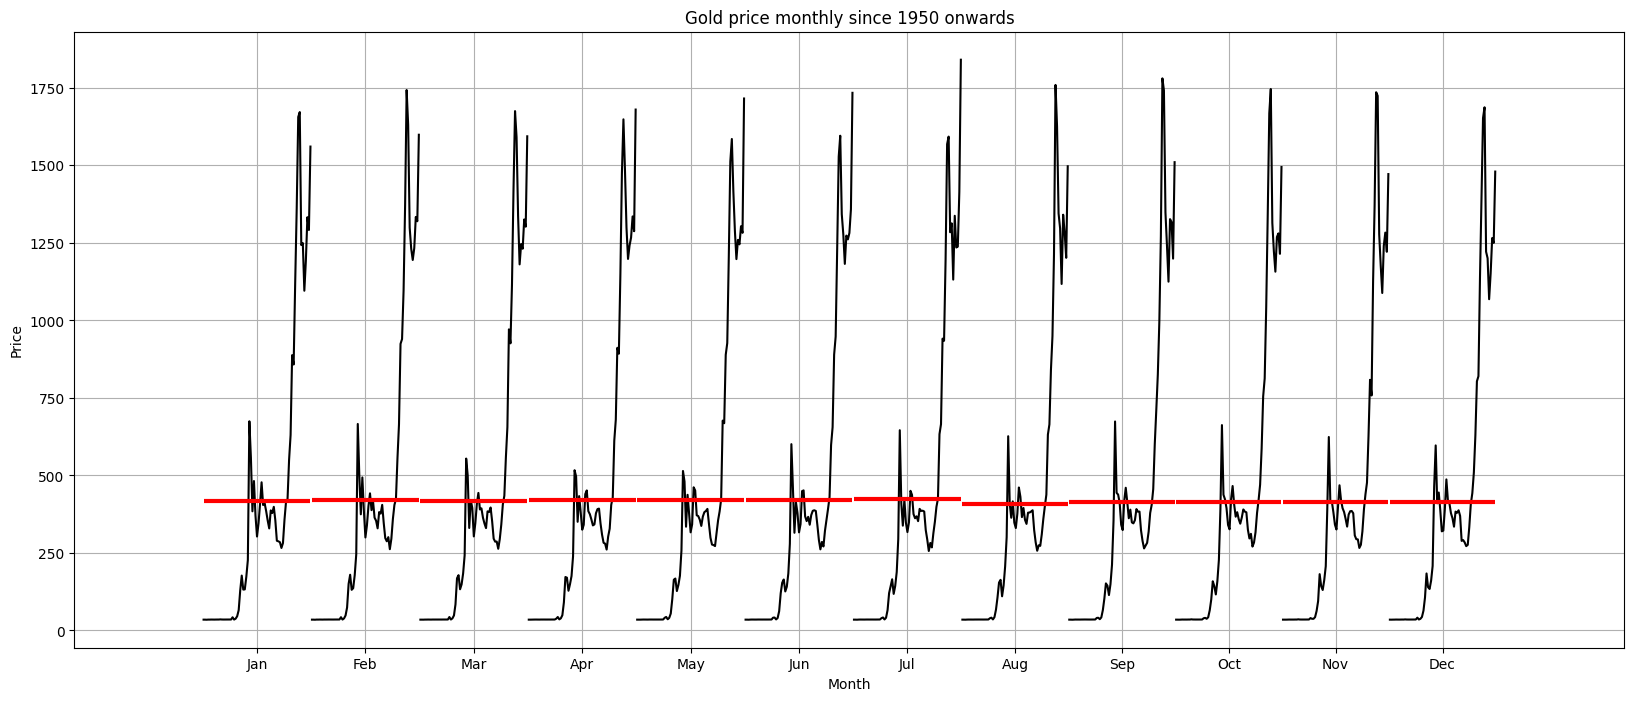

In [14]:
from statsmodels.graphics.tsaplots import month_plot

fig, ax= plt.subplots(figsize=(20,8))
month_plot(data, ylabel = 'Gold price', ax=ax)
plt.title('Gold price monthly since 1950 onwards')
plt.xlabel('Month')
plt.ylabel('Price')
plt.grid();

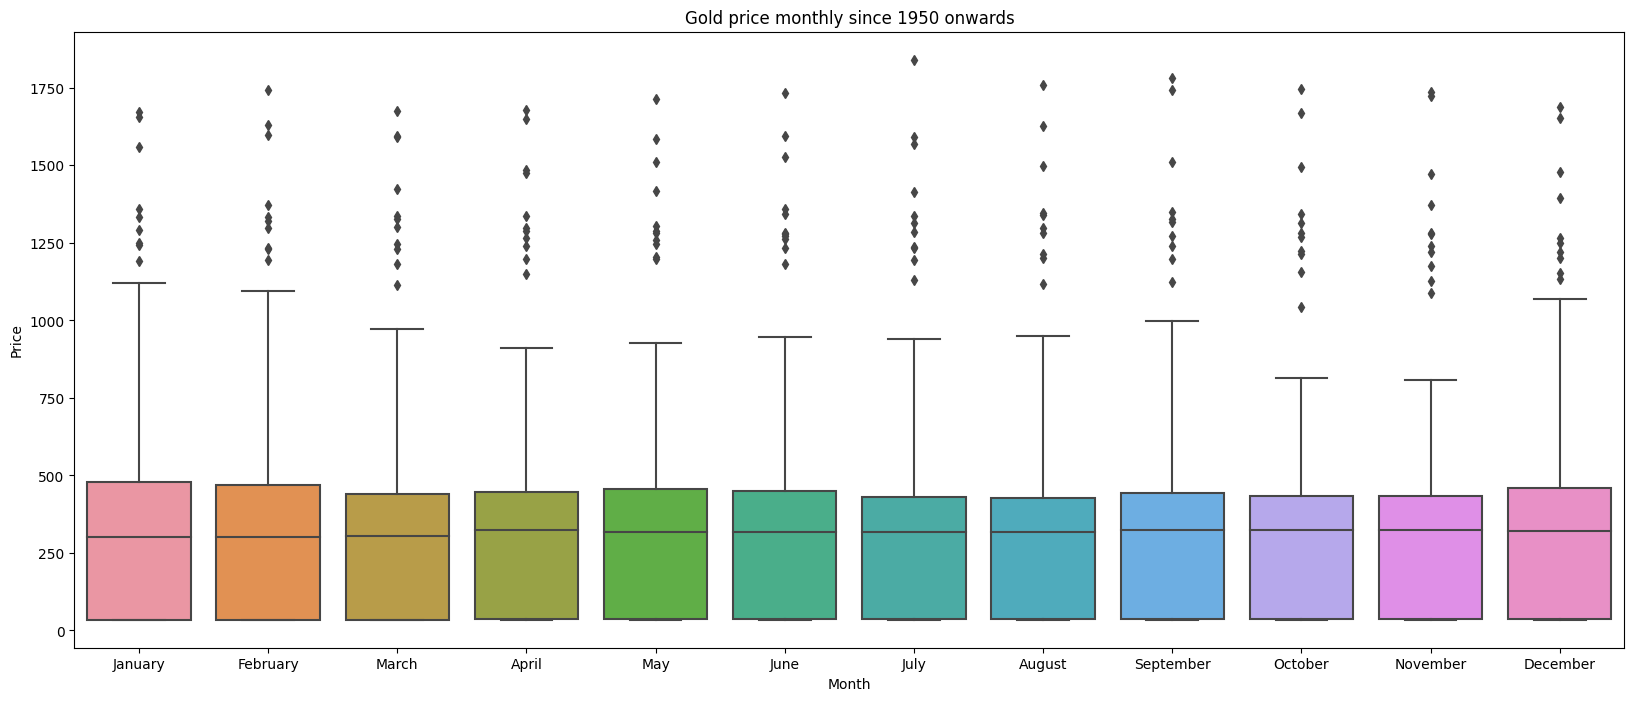

In [20]:
_, ax = plt.subplots(figsize=(20,8))
sns.boxplot(x = data.index.month_name(), y=data.values[:,0], ax=ax)
plt.title('Gold price monthly since 1950 onwards')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show();

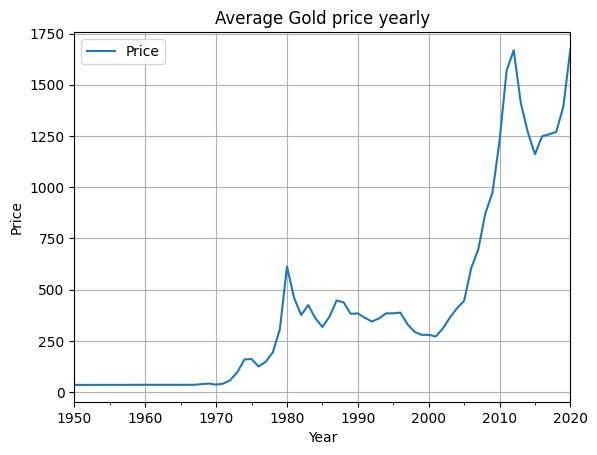

In [21]:
data_yearly_sum = data.resample('A').mean()
data_yearly_sum.plot();
plt.title('Average Gold price yearly')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid();

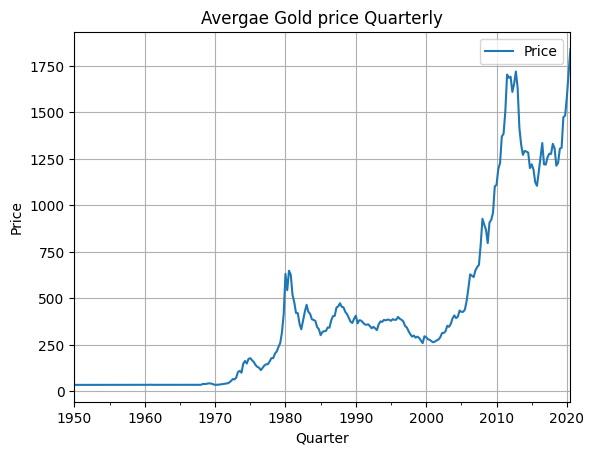

In [23]:
data_quarterly_sum = data.resample('Q').mean()
data_quarterly_sum.plot();
plt.title('Avergae Gold price Quarterly')
plt.xlabel('Quarter')
plt.ylabel('Price')
plt.grid();

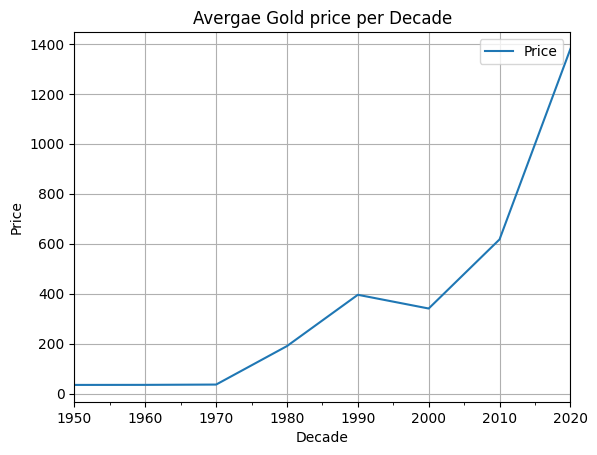

In [24]:
data_decade_sum = data.resample('10Y').mean()
data_decade_sum.plot();
plt.title('Avergae Gold price per Decade')
plt.xlabel('Decade')
plt.ylabel('Price')
plt.grid();

In [25]:
data_1 = data.groupby(data.index.year).mean().rename(columns= {'Price':'Mean'})
data_1 = data_1.merge(data.groupby(data.index.year).std().rename(columns={'Price':'Std'}), left_index= True, right_index=True)
data_1['Cov_pct']=((data_1['Std']/data_1['Mean'])*100).round(2)
data_1.head()

,Mean,Std,Cov_pct
Month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


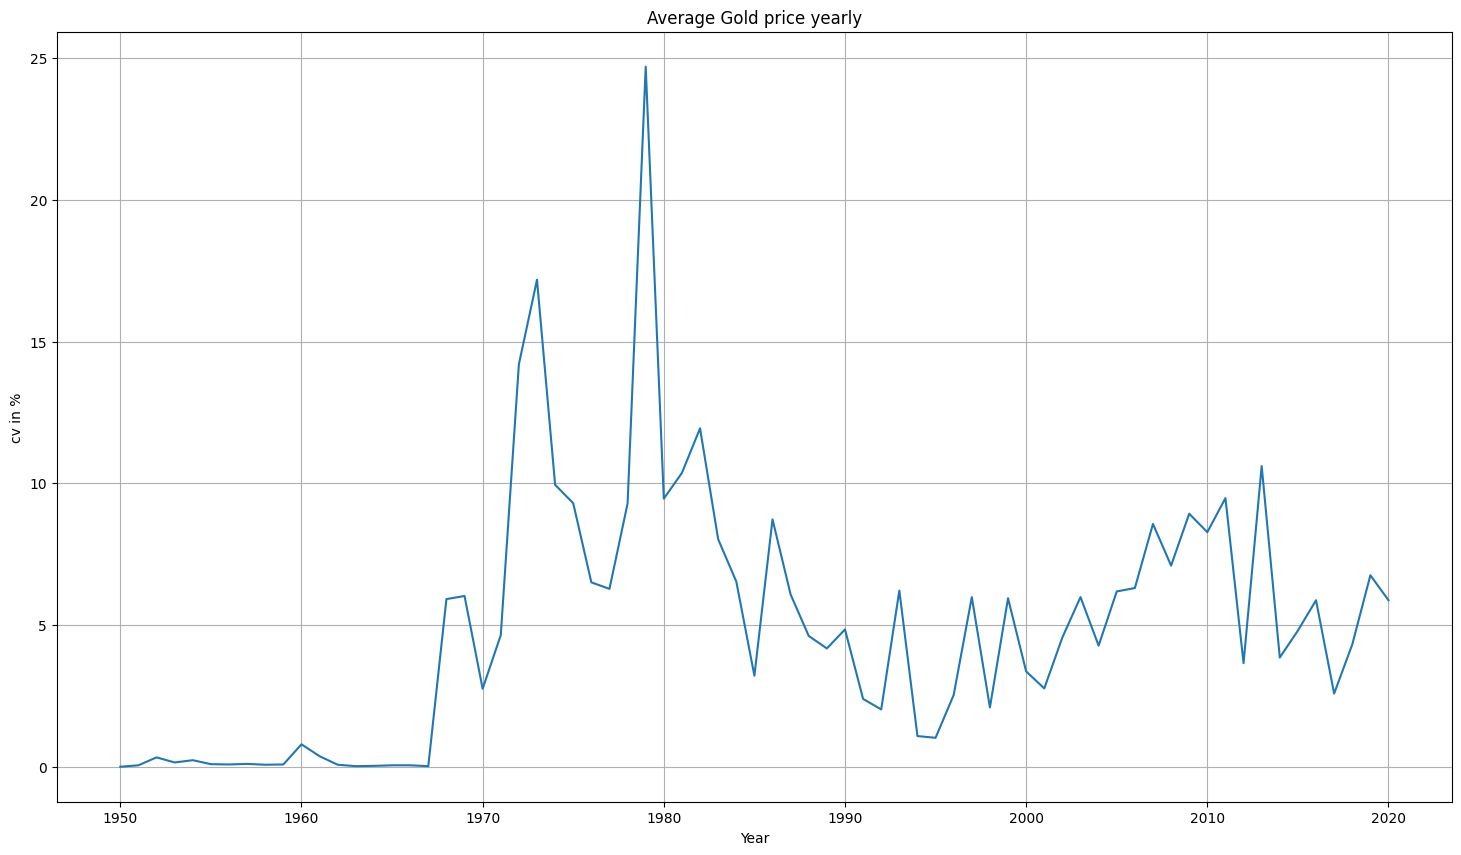

In [26]:
fig, ax = plt.subplots(figsize=(18,10))
data_1['Cov_pct'].plot();
plt.title('Average Gold price yearly')
plt.xlabel('Year')
plt.ylabel('cv in %')
plt.grid();

In [27]:
train = data[data.index.year <= 2015]
test = data[data.index.year > 2015]

In [28]:
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


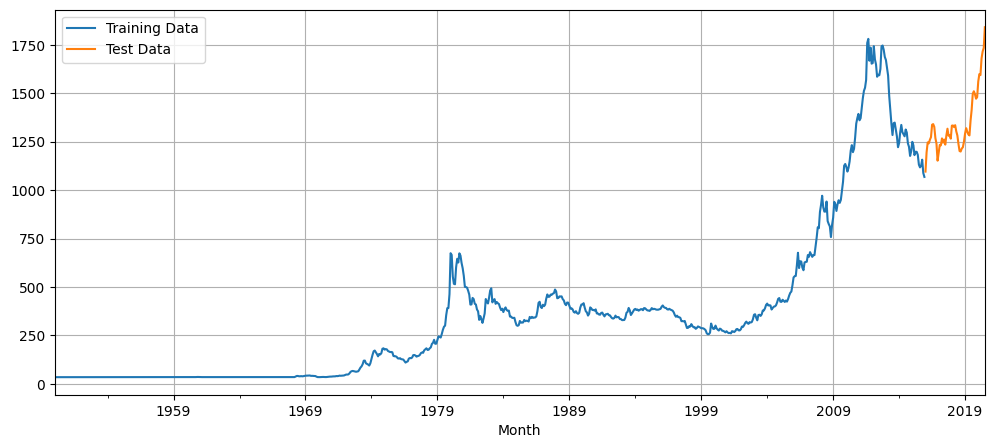

In [30]:
train['Price'].plot(figsize=(12,5), fontsize = 10)
test['Price'].plot(figsize=(12,5), fontsize = 10)
plt.grid();
plt.legend(['Training Data', 'Test Data'])
plt.show()

In [31]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(train)+1 for i in range(len(test))]
len(train_time), len(test_time)

(792, 55)

In [32]:
LR_train = train.copy()
LR_test = test.copy()

In [33]:
LR_train['time'] = train_time
LR_test['time'] = test_time

In [34]:
lr = LinearRegression()
lr.fit(LR_train[['time']],LR_train['Price'].values)

LinearRegression()

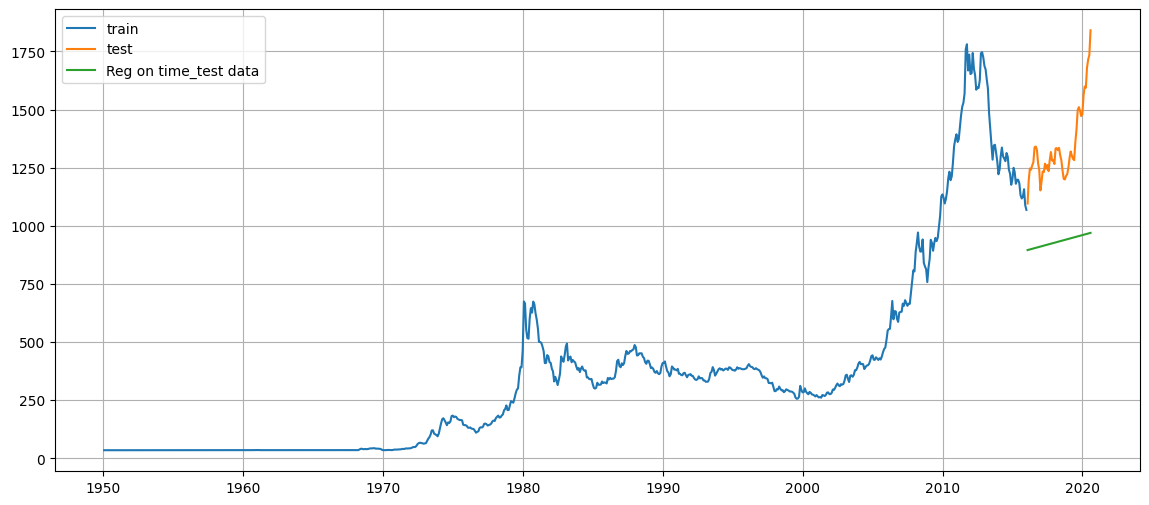

In [35]:
test_prediction_model1 = lr.predict(LR_test[['time']])
LR_test['forecast'] = test_prediction_model1
plt.figure(figsize=(14,6))
plt.plot(train['Price'], label = 'train')
plt.plot(test['Price'], label = 'test')
plt.plot(LR_test['forecast'], label = 'Reg on time_test data')
plt.legend(loc = 'best')
plt.grid();

In [37]:
def mape(actual, pred): 
    return round((np.mean(abs(actual - pred)/ actual))*100, 2)

In [39]:
mape_model1_test = mape(test['Price'].values, test_prediction_model1)
print("MAPE is %3.3f" % (mape_model1_test),"%")

MAPE is 29.760 %


In [42]:
results = pd.DataFrame({'Test Mape (%)': [mape_model1_test]}, index=['RegressionOnTime'])
results

,Test Mape (%)
RegressionOnTime,29.76


In [43]:
Naive_train = train.copy()
Naive_test = test.copy()

In [45]:
Naive_test['naive'] = np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
Naive_test['naive'].head()

Month
2016-01-31    1068.317
2016-02-29    1068.317
2016-03-31    1068.317
2016-04-30    1068.317
2016-05-31    1068.317
Name: naive, dtype: float64

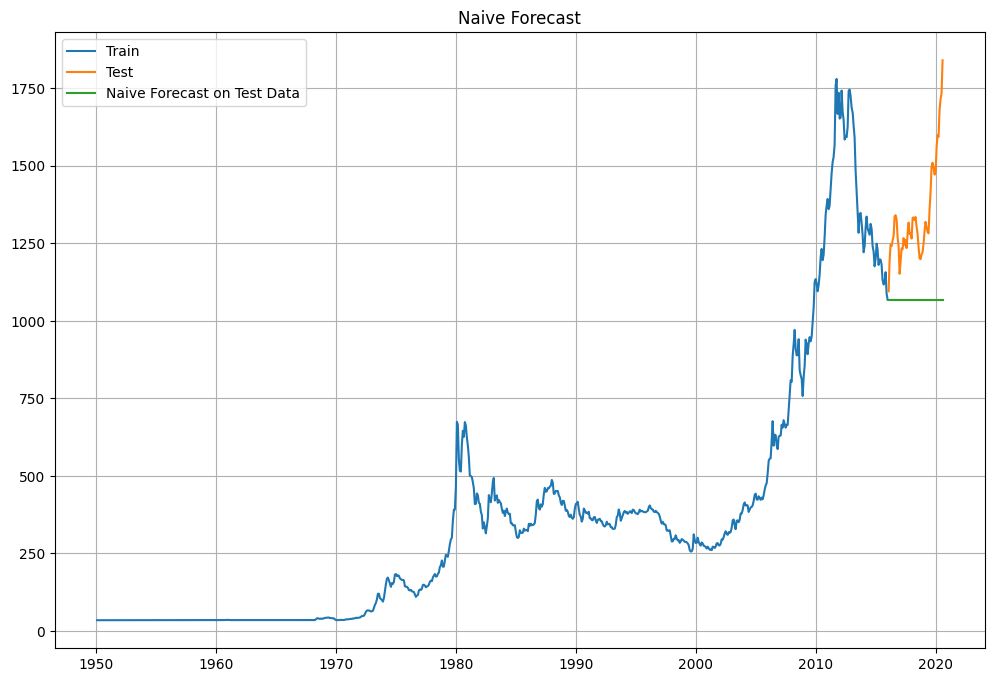

In [46]:
plt.figure(figsize=(12,8))
plt.plot(Naive_train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(Naive_test['naive'], label='Naive Forecast on Test Data')
plt.legend(loc='best')
plt.title('Naive Forecast')
plt.grid();

In [49]:
mape_model2_test = mape(test['Price'].values, Naive_test['naive'].values)
print('For Naive forecast on the Test Data, MAPE is %3.3f' %(mape_model2_test), '%')

For Naive forecast on the Test Data, MAPE is 19.380 %


In [50]:
resultsDF_2 = pd.DataFrame({'Test MAPE (%)': [mape_model2_test]}, index=['NaiveModel'])
results = pd.concat([results, resultsDF_2])
results

,Test Mape (%),Test MAPE (%)
RegressionOnTime,29.76,NaN
NaiveModel,NaN,19.38


In [51]:
final_model = ExponentialSmoothing(data, trend = 'additive',
                                seasonal = 'additive').fit(smoothing_level = 0.4,
                                                          smoothing_trend = 0.3,
                                                          smoothing_seasonal = 0.6)

In [52]:
Mape_final_model = mape(data['Price'].values, final_model.fittedvalues)
print('Mape:', Mape_final_model)

Mape: 17.24


In [53]:
predictions = final_model.forecast(steps=len(test))

In [56]:
pred_df = pd.DataFrame({'lower_CI': predictions- 1.96*np.std(final_model.resid,ddof=1), 
                        'prediction': predictions,
                        'upper_CI': predictions+ 1.96*np.std(final_model.resid,ddof=1)})
pred_df.head()

,lower_CI,prediction,upper_CI
2020-08-31,1684.718982,1792.869955,1901.020927
2020-09-30,1615.303307,1723.454279,1831.605251
2020-10-31,1538.563216,1646.714189,1754.865161
2020-11-30,1476.751963,1584.902935,1693.053908
2020-12-31,1459.318980,1567.469952,1675.620924


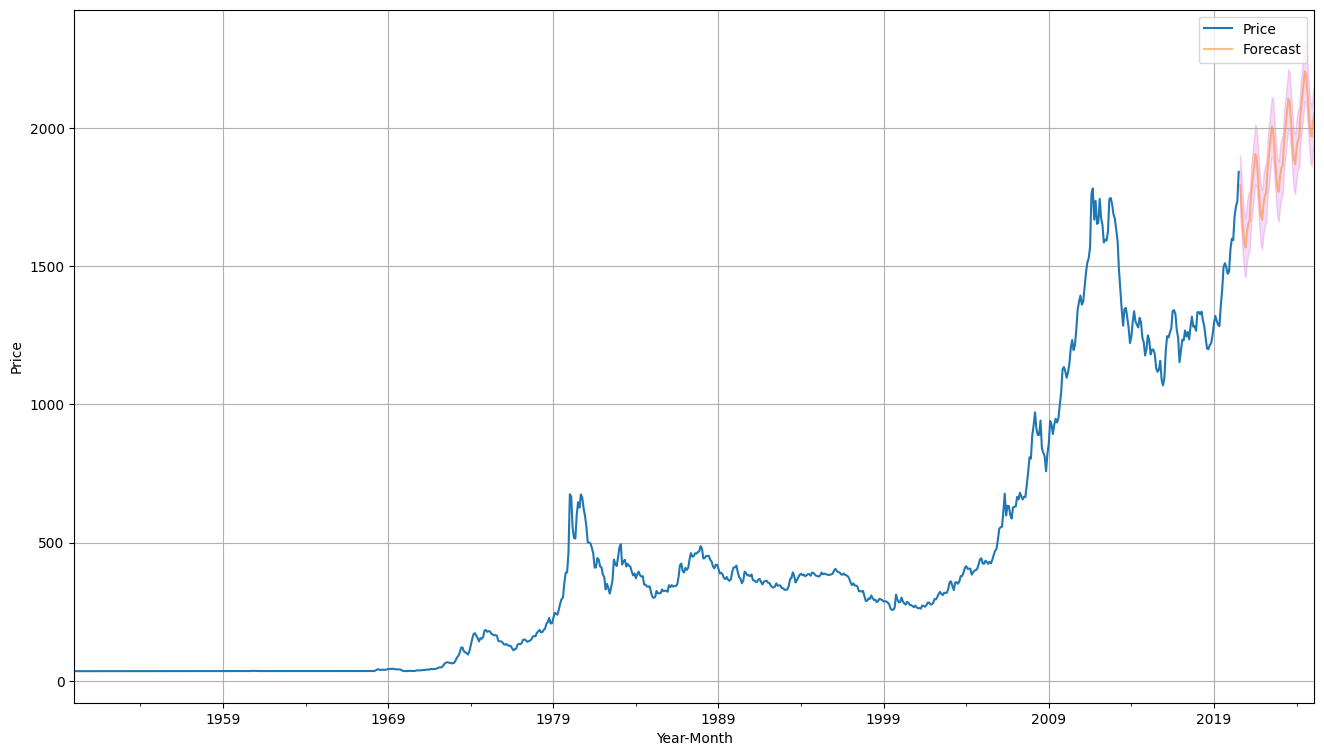

In [57]:
axis = data.plot(label = 'Actual', figsize=(16,9))
pred_df['prediction'].plot(ax= axis, label = 'Forecast', alpha = 0.5)
axis.fill_between(pred_df.index, pred_df['lower_CI'], pred_df['upper_CI'], color = 'm', alpha = 0.15)
axis.set_xlabel('Year-Month')
axis.set_ylabel('Price')
plt.legend(loc = 'best')
plt.grid()
plt.show()